# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [144]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

## Set up randomized search parameters

In [146]:
rf_param_search = {'base_estimator__n_estimators':sp.stats.randint(low=10, high=500),
                   'num_unlabeled':sp.stats.randint(low=0, high=15000),
                   'pu_learning':[False, True],
                   'base_estimator__max_features':['sqrt','log2',5, 10, 20, 50, None],
                   #todo - make custom rvs for this type of thing where I want a None some % of the time
                   'base_estimator__max_depth':sp.stats.randint(low=2, high=50),
                   'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
                   'base_estimator__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,50,100],
                   'base_estimator__class_weight':[None,'balanced','balanced_subsample']}

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [150]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(), random_state=None)

In [151]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=40, scoring=FrankenScorer(),
                                n_jobs=-1, cv=5, verbose=100, pre_dispatch=8)

#### 5x5 (x40) nested cross validation

In [152]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer(), cv=5, random_state=None)

## Score the nested cross - 1000 models!

In [153]:
scores = nested_cross.score(X_train.values, y=y_train.values, n_jobs=-1, verbose=100, pre_dispatch=8)

Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200

## The scores of the 5 folds of the outer loop.  FrankenScorer by default uses labeled_f1 metric which probably isn't what we want to use for the end result

In [154]:
scores

(0.95022624434389147,
 0.96888888888888891,
 0.93827160493827166,
 0.95716395864106352,
 0.92812499999999998)

## If we extract the nested CV metrics for all 5 folds and take the average, here is what we get across the board.  Now this is what we get if we take the best sub classifiers on "labeled_f1", so notice the 'pu_score'=1.68 which isn't good and 'pr_one_unlabled'=72%! We will need to optimize to something else even though the labeled f1 is fantastic...

In [155]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean()

fn_confusion_matrix_lab                                   20.6
tn_confusion_matrix_un                                   19499
labeled_roc_auc                                       0.930884
confusion_matrix_lab            [[159.2, 13.2], [20.6, 313.4]]
labeled_acc                                           0.933244
confusion_matrix_un        [[19499.0, 50678.2], [20.6, 313.4]]
labeled_brier_neg                                    0.0869579
labeled_prec                                          0.959948
fn_confusion_matrix_un                                    20.6
assumed_brier                                         0.380227
assumed_brier_neg                                     0.381596
labeled_brier_pos                                    0.0926726
labeled_recall                                        0.938323
assumed_f1                                           0.0170808
fp_confusion_matrix_lab                                   13.2
assumed_f1beta10                                      0

## Lets do a validation curve on a high performing random forest model to see how many estimators we need

In [37]:
params = {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 7,
  'base_estimator__max_features': 50,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 1677,
  'num_unlabeled': 10654,
  'pu_learning': False}
valid_curve_clf = PNUWrapper(RandomForestClassifier())

In [38]:
valid_curve_clf.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=50,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1677, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=10654, pu_learning=False, random_state=None,
      threshold_set_pct=None)

In [39]:
from sklearn.model_selection import validation_curve

In [40]:
param_range=[10, 50, 100, 150, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(valid_curve_clf, X_train.values, y_train.values, 'base_estimator__n_estimators',
                 param_range=param_range, cv=5, scoring=f1_assumed_beta10_scorer, n_jobs=3, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=in

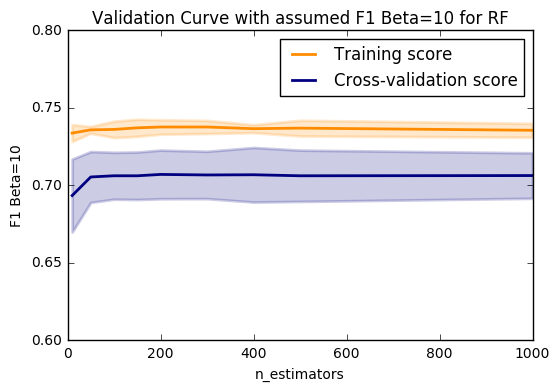

In [45]:
import matplotlib.pyplot as plt
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("n_estimators")
plt.ylabel("F1 Beta=10")
plt.ylim(0.6, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Notice the graph above it seems like the cross-val score flattens out at around 100 estimators - so that hyper-parameter may not be that important, which is good for us!

## On another note, notice the gap between training score and cross-validation score, that usually represents some level of over-fitting, so in the future we may want to cut down on the number of our features, or try simplifying our models in other ways.  The gap is small though, so it may be a non-issue as well

In [44]:
test_scores_mean

array([ 0.69341837,  0.70541213,  0.70618633,  0.70617558,  0.70705154,
        0.70670984,  0.70684229,  0.70617986,  0.7063227 ])

# Let's rerun the 1000 model search from before using 'assumed_f1beta10' metric

In [157]:
from nestedcross import rerun_nested_for_scoring

In [158]:
next_ness = rerun_nested_for_scoring(nested_cross, 'assumed_f1beta10', X_train.values, y_train.values, 
                                     how='max', n_jobs=-1, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_202650456\5244-238098416-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_202650456\5244-238098416-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_202650456\5244-238098416-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_202650456\5244-238098416-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_202650456\5244-238098416-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dty

In [161]:
next_ness.test_scores_

(0.72315656630695135,
 0.72594481799211685,
 0.67940721649484548,
 0.69010416666666652,
 0.71112192124532747)

## Notice above that it took 8 minutes to run a search over 1000 models for a new metric. It only had to fit 5 new models to determine what the new metric would generalize to if using it to optimize a hyperparameter search.

# Let's dive in and see the parameters for one of the best models

In [162]:
scores = extract_score_grid(next_ness.estimators_[1])

In [168]:
scores.mean_assumed_f1beta10_test.idxmax()

39

In [170]:
next_ness.estimators_[1].cv_results_['params'][39]

{'base_estimator__class_weight': 'balanced',
 'base_estimator__max_depth': 48,
 'base_estimator__max_features': None,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 0.15,
 'base_estimator__n_estimators': 56,
 'num_unlabeled': 8303,
 'pu_learning': True}

## Below is that specific model's test set scores in the inner loop.  These can't really be used in any comparison since they are biased but interesting to see.  Notice PU-score of 8.45, recall 0.8, precicion 0.92, pr_one_unlabeled = 7.23%.

In [175]:
scores.iloc[39][[c for c in scores.columns if 'test' in c and 'mean' in c]]

mean_labeled_f1_test                  0.856709
mean_labeled_recall_test              0.800866
mean_labeled_acc_test                 0.823706
mean_fp_confusion_matrix_lab_test         18.2
mean_labeled_brier_test               0.139352
mean_fn_confusion_matrix_un_test          53.2
mean_tp_confusion_matrix_lab_test          214
mean_tp_confusion_matrix_un_test           214
mean_tn_confusion_matrix_lab_test        119.6
mean_confusion_matrix_lab_test             NaN
mean_assumed_f1_test                 0.0940348
mean_labeled_brier_neg_test           0.176591
mean_confusion_matrix_un_test              NaN
mean_assumed_f1beta10_test            0.697099
mean_labeled_prec_test                0.921553
mean_tn_confusion_matrix_un_test       52071.8
mean_labeled_roc_auc_test             0.834422
mean_assumed_brier_test              0.0920031
mean_pu_score_test                     8.45788
mean_labeled_brier_pos_test           0.120156
mean_fn_confusion_matrix_lab_test         53.2
mean_assumed_

In [189]:
extract_scores_from_nested(next_ness.test_score_datas_).mean()

fn_confusion_matrix_lab                                  62.4
tn_confusion_matrix_un                                64991.6
labeled_roc_auc                                      0.796337
confusion_matrix_lab           [[134.4, 38.0], [62.4, 271.6]]
labeled_acc                                          0.801717
confusion_matrix_un        [[64991.6, 5185.6], [62.4, 271.6]]
labeled_brier_neg                                    0.179147
labeled_prec                                         0.880482
fn_confusion_matrix_un                                   62.4
assumed_brier                                       0.0756377
assumed_brier_neg                                   0.0753697
labeled_brier_pos                                    0.131953
labeled_recall                                       0.813174
assumed_f1                                          0.0938105
fp_confusion_matrix_lab                                    38
assumed_f1beta10                                     0.705947
tp_confu

# Quick side-project - lets test how using every sample in RF would work

In [190]:
params = {'base_estimator__class_weight': 'balanced',
 'base_estimator__max_depth': 48,
 'base_estimator__max_features': None,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 0.15,
 'base_estimator__n_estimators': 56,
 'num_unlabeled': 8303,
 'pu_learning': True}

In [191]:
pnu.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=8303, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [192]:
pnu.set_params(num_unlabeled=1.0, base_estimator__n_jobs=-1, base_estimator__verbose=100)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [193]:
pnu.fit(X_train.values, y_train.values)

building tree 1 of 56
building tree 2 of 56building tree 3 of 56

building tree 4 of 56
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.0s
building tree 5 of 56
building tree 6 of 56[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min

building tree 7 of 56[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min

building tree 8 of 56[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min

building tree 9 of 56[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min

building tree 10 of 56[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.5min

building tree 11 of 56[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.2min

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.2min
building tree 12 of 56
building tree 13 of 56[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min

building tree 14 of 56[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min

[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.0min
build

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=None, verbose=100,
            warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [194]:
FrankenScorer()(pnu, X_test.values, y_test.values)

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

({'SCORE': 0.85750315258511978,
  'assumed_brier': 0.091195101702102765,
  'assumed_brier_neg': 0.091114022714035986,
  'assumed_f1': 0.095720720720720714,
  'assumed_f1beta10': 0.70824567916511982,
  'confusion_matrix_lab': array([[180,  35],
         [ 78, 340]]),
  'confusion_matrix_un': array([[81376,  6346],
         [   78,   340]]),
  'labeled_acc': 0.82148499210110582,
  'labeled_avg_prec': 0.92164327233421772,
  'labeled_brier': 0.14535843324231648,
  'labeled_brier_neg': 0.21758104530099154,
  'labeled_brier_pos': 0.10821043900161041,
  'labeled_f1': 0.85750315258511978,
  'labeled_prec': 0.90666666666666662,
  'labeled_recall': 0.8133971291866029,
  'labeled_roc_auc': 0.82530321575609211,
  'pr_one_unlabeled': 0.072119944690139076,
  'pu_score': 8.7219168986300168},
 0.85750315258511978)

## Hmmm - lets do a validation curve on this - I think it caps out at around 10,000 unlabeled

In [195]:
param_range=[0,500,1000,2000,5000,7500,10000,15000]
train_scores, test_scores = validation_curve(pnu, X_train.values, y_train.values, 'num_unlabeled',
                 param_range=param_range, cv=3, scoring=f1_assumed_beta10_scorer, n_jobs=-1, verbose=100)

Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(39,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(39, 1, 2), dtype=float64).
Pickling array (shape=(2,), dtype=float64).
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(61,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(61, 1, 2), dtype=float64).
Pickling array (shape=(2,), dtype=float64).
Pickling array (shape=(1,), dtype=int64).
Pickling array (shape=(69,), dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]).
Pickling array (shape=(69, 1, 2), dtype=float64).
Pic

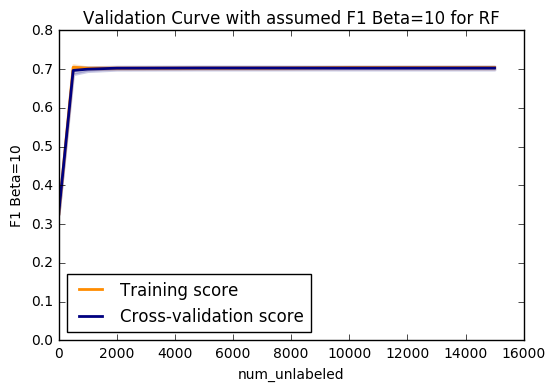

In [197]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("num_unlabeled")
plt.ylabel("F1 Beta=10")
plt.ylim(0.0, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()